In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Introduction : Story of transfer learning in NLP
In early 2018, Jeremy Howard (co-founder of fast.ai) and Sebastian Ruder introduced the  [Universal Language Model Fine-tuning for Text Classification](https://medium.com/r/?url=https%3A%2F%2Farxiv.org%2Fpdf%2F1801.06146.pdf) (ULMFiT) method. ULMFiT was the first **Transfer Learning** method applied to NLP. As a result, besides significantly outperforming many state-of-the-art tasks, it allowed, with only 100 labeled examples, to match performances equivalent to models trained on 100×  more data.

Key techniques in ULMFiT to fine-tune the models are **Discriminate Learning Rate**, **Gradual Unfreezing** or **Slanted Triangular Learning Rates**.

Since the introduction of ULMFiT, **Transfer Learning** became very popular in NLP and yet Google (BERT, Transformer-XL, XLNet), Facebook (RoBERTa, XLM) or even OpenAI (GPT, GPT-2) begin to pre-train their own model on very large corpora. This time, instead of using the AWD-LSTM neural network, they all used a more powerful architecture based on the Transformer (cf. [Attention is all you need](https://arxiv.org/abs/1706.03762)).

Although these models are powerful, ``fastai`` do not integrate all of them. Fortunately, [HuggingFace](https://huggingface.co/) 🤗 created the well know [transformers library](https://github.com/huggingface/transformers). Formerly knew as ``pytorch-transformers`` or ``pytorch-pretrained-bert``, this library brings together over 40 state-of-the-art pre-trained NLP models (BERT, GPT-2, RoBERTa, CTRL…). The implementation gives interesting additional utilities like tokenizer, optimizer or scheduler.

The ``transformers`` library can be self-sufficient but incorporating it within the ``fastai`` library provides simpler implementation compatible with powerful fastai tools like  **Discriminate Learning Rate**, **Gradual Unfreezing** or **Slanted Triangular Learning Rates**. 




#  Integrating transformers with fastai for multiclass classification
Before beginning the implementation, note that integrating ``transformers`` within ``fastai`` can be done in multiple different ways. I had change minimal amount of code in both the libraries and have implemented the multiclass classification.



## Libraries Installation
Installation Instructions for the FastAI and HuggingFace Transformers are [here](https://github.com/fastai/fastai/blob/master/README.md#installation) and [here](https://github.com/huggingface/transformers#installation) respectively.

In [2]:
!pip install -q transformers==2.1.1
!pip install -q torch

     |████████████████████████████████| 317kB 9.6MB/s 
     |████████████████████████████████| 901kB 17.2MB/s 
     |████████████████████████████████| 1.2MB 40.2MB/s 
     |████████████████████████████████| 133kB 51.1MB/s 
     |████████████████████████████████| 81kB 12.2MB/s 
     |████████████████████████████████| 7.7MB 46.1MB/s 
ERROR: botocore 1.20.104 has requirement urllib3<1.27,>=1.25.4, but you'll have urllib3 1.24.3 which is incompatible.


In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pathlib import Path 

import os

import torch
import torch.optim as optim

import random 

# fastai
from fastai import *
from fastai.text import *
from fastai.callbacks import *

# transformers
from transformers import PreTrainedModel, PreTrainedTokenizer, PretrainedConfig
from transformers import RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig

The used versions of the fastai and transformers libraries are respectively 1.0.61 and 2.1.1.

In [4]:
import fastai
import transformers
print('fastai version :', fastai.__version__)
print('transformers version :', transformers.__version__)

fastai version : 1.0.61
transformers version : 2.1.1


## Sentiment Analysis of Tweets related to COVID-19.
The task is to classify the tweets data into classes based on their sentiment.

For each tweet, the model has to predict a label for the sentiment. We evaluate the outputs of the model on classification accuracy. The sentiment labels are:
* 0 → Negative
* 1 → Neutral
* 2 → Positive

The data is loaded into a ``DataFrame`` using ``pandas``.

In [5]:
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Internship Dataset/RoBERTa Model/Final_Datasets'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/drive/MyDrive/Internship Dataset/RoBERTa Model/Final_Datasets/Data.csv
/content/drive/MyDrive/Internship Dataset/RoBERTa Model/Final_Datasets/Test_India.csv
/content/drive/MyDrive/Internship Dataset/RoBERTa Model/Final_Datasets/Test_Data.csv
/content/drive/MyDrive/Internship Dataset/RoBERTa Model/Final_Datasets/Train_Data.csv


In [6]:
DATA_ROOT = Path("..") / '/content/drive/MyDrive/Internship Dataset/RoBERTa Model/Final_Datasets'
train = pd.read_csv(DATA_ROOT / 'Test_Data.csv')
test = pd.read_csv(DATA_ROOT / 'Test_India.csv')

## Main transformers classes
In ``transformers``, each model architecture is associated with 3 main types of classes:
* A **model class** to load/store a particular pre-train model.
* A **tokenizer class** to pre-process the data and make it compatible with a particular model.
* A **configuration class** to load/store the configuration of a particular model.



In [7]:
MODEL_CLASSES = {'roberta': (RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig)}

You will see later, that those classes share a common class method ``from_pretrained(pretrained_model_name, ...)``. In my case, the parameter ``pretrained_model_name`` is a string with the shortcut name of a pre-trained model/tokenizer/configuration to load, e.g ``'bert-base-uncased'``. We can find all the shortcut names in the transformers documentation [here](https://huggingface.co/transformers/pretrained_models.html#pretrained-models).

In [8]:
# Parameters
seed = 42
use_fp16 = False
bs = 16

model_type = 'roberta'
pretrained_model_name = 'roberta-base'

# model_type = 'bert'
# pretrained_model_name='bert-base-uncased'

# model_type = 'distilbert'
# pretrained_model_name = 'distilbert-base-uncased'

#model_type = 'xlm'
#pretrained_model_name = 'xlm-clm-enfr-1024'

# model_type = 'xlnet'
# pretrained_model_name = 'xlnet-base-cased'

In [9]:
model_class, tokenizer_class, config_class = MODEL_CLASSES[model_type]

Print the available values for ``pretrained_model_name`` (shortcut names) corresponding to the ``model_type`` used.


In [10]:
model_class.pretrained_model_archive_map.keys()

dict_keys(['roberta-base', 'roberta-large', 'roberta-large-mnli'])

## Util function

Function to set the seed for generating random numbers.

In [11]:
def seed_all(seed_value):
    random.seed(seed_value) # Python
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False

In [12]:
seed_all(seed)

## Data pre-processing

To match pre-training, we have to format the model input sequence in a specific format.
To do so, we have to first **tokenize** and then **numericalize** the texts correctly.
The difficulty here is that each pre-trained model, that we will fine-tune, requires exactly the same specific pre-process - **tokenization** & **numericalization** - than the pre-process used during the pre-train part.
Fortunately, the **tokenizer class** from ``transformers`` provides the correct pre-process tools that correspond to each pre-trained model.

In the ``fastai`` library, data pre-processing is done automatically during the creation of the ``DataBunch``. 
As you will see in the ``DataBunch`` implementation, the **tokenizer** and **numericalizer** are passed in the processor argument under the following format :

``processor = [TokenizeProcessor(tokenizer=tokenizer,...), NumericalizeProcessor(vocab=vocab,...)]``

### Custom Tokenizer
From the fastai documentation we see that:
1. The [``TokenizeProcessor`` object](https://docs.fast.ai/text.data.html#TokenizeProcessor) takes as ``tokenizer`` argument a ``Tokenizer`` object.
2. The [``Tokenizer`` object](https://docs.fast.ai/text.transform.html#Tokenizer) takes as ``tok_func`` argument a ``BaseTokenizer`` object.
3. The [``BaseTokenizer`` object](https://docs.fast.ai/text.transform.html#BaseTokenizer) implement the function ``tokenizer(t:str) → List[str]`` that take a text ``t`` and returns the list of its tokens.

Therefore, we can simply create a new class ``TransformersBaseTokenizer`` that inherits from ``BaseTokenizer`` and overwrite a new ``tokenizer`` function.


In [13]:
class TransformersBaseTokenizer(BaseTokenizer):
    """Wrapper around PreTrainedTokenizer to be compatible with fast.ai"""
    def __init__(self, pretrained_tokenizer: PreTrainedTokenizer, model_type = 'bert', **kwargs):
        self._pretrained_tokenizer = pretrained_tokenizer
        self.max_seq_len = pretrained_tokenizer.max_len
        self.model_type = model_type

    def __call__(self, *args, **kwargs): 
        return self

    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length and add the spesial tokens"""
        CLS = self._pretrained_tokenizer.cls_token
        SEP = self._pretrained_tokenizer.sep_token
        if self.model_type in ['roberta']:
            tokens = self._pretrained_tokenizer.tokenize(t, add_prefix_space=True)[:self.max_seq_len - 2]
            tokens = [CLS] + tokens + [SEP]
        else:
            tokens = self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2]
            if self.model_type in ['xlnet']:
                tokens = tokens + [SEP] +  [CLS]
            else:
                tokens = [CLS] + tokens + [SEP]
        return tokens

In [14]:
transformer_tokenizer = tokenizer_class.from_pretrained(pretrained_model_name)
transformer_base_tokenizer = TransformersBaseTokenizer(pretrained_tokenizer = transformer_tokenizer, model_type = model_type)
fastai_tokenizer = Tokenizer(tok_func = transformer_base_tokenizer, pre_rules=[], post_rules=[])

100%|██████████| 456318/456318 [00:00<00:00, 1471545.65B/s]


In this implementation, care was taken about 3 things :
1. As we are not using RNN, we have to limit the sequence length to the model input size.
2. Most of the models require special tokens placed at the beginning and end of the sequences.
3. Some models like RoBERTa require a space to start the input string. For those models, the encoding methods should be called with ``add_prefix_space`` set to ``True``.



### Custom Numericalizer

In ``fastai``, [``NumericalizeProcessor``  object](https://docs.fast.ai/text.data.html#NumericalizeProcessor) takes as ``vocab`` argument a [``Vocab`` object](https://docs.fast.ai/text.transform.html#Vocab). 

In [15]:
class TransformersVocab(Vocab):
    def __init__(self, tokenizer: PreTrainedTokenizer):
        super(TransformersVocab, self).__init__(itos = [])
        self.tokenizer = tokenizer
    
    def numericalize(self, t:Collection[str]) -> List[int]:
        "Convert a list of tokens `t` to their ids."
        return self.tokenizer.convert_tokens_to_ids(t)
        #return self.tokenizer.encode(t)

    def textify(self, nums:Collection[int], sep=' ') -> List[str]:
        "Convert a list of `nums` to their tokens."
        nums = np.array(nums).tolist()
        return sep.join(self.tokenizer.convert_ids_to_tokens(nums)) if sep is not None else self.tokenizer.convert_ids_to_tokens(nums)
    
    def __getstate__(self):
        return {'itos':self.itos, 'tokenizer':self.tokenizer}

    def __setstate__(self, state:dict):
        self.itos = state['itos']
        self.tokenizer = state['tokenizer']
        self.stoi = collections.defaultdict(int,{v:k for k,v in enumerate(self.itos)})

NB: The functions ``__gestate__`` and ``__setstate__`` allow the functions [export](https://docs.fast.ai/basic_train.html#Learner.export) and [load_learner](https://docs.fast.ai/basic_train.html#load_learner) to work correctly with ``TransformersVocab``.

### Custom processor
Now that we have our custom **tokenizer** and **numericalizer**, we can create the custom **processor**. Notice we are passing the ``include_bos = False`` and ``include_eos = False`` options. This is because ``fastai`` adds its own special tokens by default which interferes with the ``[CLS]`` and ``[SEP]`` tokens added by our custom tokenizer.

In [16]:
transformer_vocab =  TransformersVocab(tokenizer = transformer_tokenizer)
numericalize_processor = NumericalizeProcessor(vocab=transformer_vocab)

tokenize_processor = TokenizeProcessor(tokenizer=fastai_tokenizer, include_bos=False, include_eos=False)

transformer_processor = [tokenize_processor, numericalize_processor]

## Setting up the Databunch
For the DataBunch creation, you have to pay attention to set the processor argument to our new custom processor ``transformer_processor`` and manage correctly the padding.

As mentioned in the HuggingFace documentation RoBERTa model is  with absolute position embeddings, so it's usually advised to pad the inputs on the right rather than the left. 

In [17]:
pad_first = bool(model_type in ['xlnet'])
pad_idx = transformer_tokenizer.pad_token_id

In [18]:
tokens = transformer_tokenizer.tokenize('Salut c est moi, Hello it s me')
print(tokens)
ids = transformer_tokenizer.convert_tokens_to_ids(tokens)
print(ids)
transformer_tokenizer.convert_ids_to_tokens(ids)


['Sal', 'ut', 'Ġc', 'Ġest', 'Ġmo', 'i', ',', 'ĠHello', 'Ġit', 'Ġs', 'Ġme']
[18111, 1182, 740, 3304, 7458, 118, 6, 20920, 24, 579, 162]


['Sal', 'ut', 'Ġc', 'Ġest', 'Ġmo', 'i', ',', 'ĠHello', 'Ġit', 'Ġs', 'Ġme']

There is multible ways to create a DataBunch, in our implementation, we used 
[the data block API](https://docs.fast.ai/data_block.html#The-data-block-API), which gives more flexibility.

In [19]:
databunch = (TextList.from_df(train, cols='full_text', processor=transformer_processor)
             .split_by_rand_pct(0.1,seed=seed)
             .label_from_df(cols= 'Sentiment')
             .add_test(test)
             .databunch(bs=bs, pad_first=pad_first, pad_idx=pad_idx))

/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Check batch and tokenizer :

In [20]:
print('[CLS] token :', transformer_tokenizer.cls_token)
print('[SEP] token :', transformer_tokenizer.sep_token)
print('[PAD] token :', transformer_tokenizer.pad_token)
databunch.show_batch()

[CLS] token : <s>
[SEP] token : </s>
[PAD] token : <pad>


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


text,target
<s> Ġ@ Happy Ms R ox Ġ@ An on __ Tr uther Ġ@ bent ual dep ine ut Ġ@ str anger _ po etry Ġ@ S ami S oder lund Ġ@ U ry l le Ġ@ For Free Spe ech 1 Ġ@ bill Bel 809 25 644 Ġ@ 400 fort y four Ġ@ The Gaming Ground Ġ@ p uf p uf p af p af Ġ@ Di ur p ag,negative
<s> ĠðŁ ĩ ª ðŁ ĩ ¸ ðŁ ĩ ª ðŁ ĩ ¸ ðŁ ĩ ª ðŁ ĩ ¸ ðŁ ĩ ª ðŁ ĩ ¸ ðŁ ĩ ª ðŁ ĩ ¸ ðŁ ĩ ª ðŁ ĩ ¸ ðŁ ĩ ª ðŁ ĩ ¸ ðŁ ĩ ª ðŁ ĩ ¸ ðŁ ĩ ª ðŁ ĩ ¸ ðŁ ĩ ª ðŁ ĩ ¸ ðŁ ĩ ª ðŁ ĩ ¸ Ċ Ġ Ġ,neutral
<s> ĠSport Ġdead Ġme ĠðŁ ¤ ª ðŁ Ĵ ¦ ĠEven ĠCorona Ġis Ġthere ĠI Ġneed Ġto Ġstay Ġfit ĠðŁ Ĵ ª ðŁ ı ¼ ðŁ § ¬ âľ Į ðŁ ı ½ Ċ . Ċ . Ċ . Ċ . Ċ . Ċ Hash tags : Ġ# as ian b abe Ġ# as iang irl Ġ# as ian Ġ# k orea Ġ# k pop Ġ# bl ond Ġ# b,positive
<s> Ġâ ģ ¦ ST OP Ġthe Ġmisinformation ! F lu Ġv ax Ġmakes ĠCorona ĠWOR SE . Ġâ ģ ¦ @ and erson co oper âģ © Ġâ ģ ¦ @ d rs an jay gu pta âģ © Ġâ ģ ¦ @ c nn br k âģ © Ġâ ģ ¦ @ CNN âģ © Ġ ĠPl z ĠCONS ULT : Ġâ ģ ¦ @ pic phys icians,negative
"<s> ĠI 'm Ġopen - s ourcing Ġa Ġcommand Ġline ĠCLI ĠI Ġwrote , Ġto Ġtrack Ġthe Ġlatest Ġstats Ġof ĠCor on av irus Ġdisease Ġ( CO VID - 19 ). Ċ Ċ âĿ ¯ âĿ ¯ Ġhttps :// t . co / i F AA b 7 h x Z 9 Ċ Ċ INST ALL : Ċ ðŁ ĵ Ł Ġnpm Ġi Ġ- g Ġcor ona - cli Ċ",negative


Check batch and numericalizer :

In [21]:
print('[CLS] id :', transformer_tokenizer.cls_token_id)
print('[SEP] id :', transformer_tokenizer.sep_token_id)
print('[PAD] id :', pad_idx)
test_one_batch = databunch.one_batch()[0]
print('Batch shape : ',test_one_batch.shape)
print(test_one_batch)

[CLS] id : 0
[SEP] id : 2
[PAD] id : 1
Batch shape :  torch.Size([16, 383])
tensor([[    0,   787, 21136,  ...,   242,   387,     2],
        [    0,   787,   495,  ...,     1,     1,     1],
        [    0,    22, 40756,  ...,     1,     1,     1],
        ...,
        [    0, 11733,   697,  ...,     1,     1,     1],
        [    0,   787, 45831,  ...,     1,     1,     1],
        [    0,   787, 18216,  ...,     1,     1,     1]])


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


### Custom model
As mentioned [here](https://github.com/huggingface/transformers#models-always-output-tuples), every model's forward method always outputs a ``tuple`` with various elements depending on the model and the configuration parameters. In our case, we are interested to access only to the logits. 
One way to access them is to create a custom model.

In [22]:
# defining our model architecture 
class CustomTransformerModel(nn.Module):
    def __init__(self, transformer_model: PreTrainedModel):
        super(CustomTransformerModel,self).__init__()
        self.transformer = transformer_model
        
    def forward(self, input_ids, attention_mask=None):
        
        # attention_mask
        # Mask to avoid performing attention on padding token indices.
        # Mask values selected in ``[0, 1]``:
        # ``1`` for tokens that are NOT MASKED, ``0`` for MASKED tokens.
        attention_mask = (input_ids!=pad_idx).type(input_ids.type()) 
        
        logits = self.transformer(input_ids,
                                  attention_mask = attention_mask)[0]   
        return logits

To make our transformers adapted to multiclass classification, before loading the pre-trained model, we need to precise the number of labels.

In [23]:
config = config_class.from_pretrained(pretrained_model_name)
config.num_labels = 3
config.use_bfloat16 = use_fp16
print(config)

100%|██████████| 481/481 [00:00<00:00, 79725.75B/s]

{
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_id": 2,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 3,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true,
  "pad_token_id": 1,
  "pruned_heads": {},
  "torchscript": false,
  "type_vocab_size": 1,
  "use_bfloat16": false,
  "vocab_size": 50265
}



In [24]:
transformer_model = model_class.from_pretrained(pretrained_model_name, config = config)
# transformer_model = model_class.from_pretrained(pretrained_model_name, num_labels = 5)

custom_transformer_model = CustomTransformerModel(transformer_model = transformer_model)

100%|██████████| 501200538/501200538 [00:26<00:00, 18571952.34B/s]


## Learner : Custom Optimizer / Custom Metric
In ``pytorch-transformers``, HuggingFace had implemented two specific optimizers  -  BertAdam and OpenAIAdam  -  that have been replaced by a single AdamW optimizer.
Thus we will be using the AdamW Optimiser in our process.

In [25]:
from fastai.callbacks import *
from transformers import AdamW
from functools import partial

CustomAdamW = partial(AdamW, correct_bias=False)

learner = Learner(databunch, 
                  custom_transformer_model, 
                  opt_func = CustomAdamW, 
                  metrics=[accuracy, error_rate])

# Show graph of learner stats and metrics after each epoch.
learner.callbacks.append(ShowGraph(learner))

# Put learn in FP16 precision mode. --> Seems to not working
if use_fp16: learner = learner.to_fp16()

## Discriminative Fine-tuning and Gradual unfreezing (Optional)
To use **discriminative layer training** and **gradual unfreezing**, ``fastai`` provides one tool that allows to "split" the structure model into groups. An instruction to perform that "split" is described in the fastai documentation [here](https://docs.fast.ai/basic_train.html#Discriminative-layer-training).

 We use the RobBERTa model and observe the architecture by making ``print(learner.model)``.

In [26]:
print(learner.model)

CustomTransformerModel(
  (transformer): RobertaForSequenceClassification(
    (roberta): RobertaModel(
      (embeddings): RobertaEmbeddings(
        (word_embeddings): Embedding(50265, 768, padding_idx=1)
        (position_embeddings): Embedding(514, 768, padding_idx=1)
        (token_type_embeddings): Embedding(1, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(i

We can decide to divide the model in 14 blocks :
* 1 Embedding
* 12 transformer
* 1 classifier

In this case, we can split our model in this way :

In [27]:

# For roberta-base
list_layers = [learner.model.transformer.roberta.embeddings,
              learner.model.transformer.roberta.encoder.layer[0],
              learner.model.transformer.roberta.encoder.layer[1],
              learner.model.transformer.roberta.encoder.layer[2],
              learner.model.transformer.roberta.encoder.layer[3],
              learner.model.transformer.roberta.encoder.layer[4],
              learner.model.transformer.roberta.encoder.layer[5],
              learner.model.transformer.roberta.encoder.layer[6],
              learner.model.transformer.roberta.encoder.layer[7],
              learner.model.transformer.roberta.encoder.layer[8],
              learner.model.transformer.roberta.encoder.layer[9],
              learner.model.transformer.roberta.encoder.layer[10],
              learner.model.transformer.roberta.encoder.layer[11],
              learner.model.transformer.roberta.pooler]

Check groups : 

In [28]:
learner.split(list_layers)
num_groups = len(learner.layer_groups)
print('Learner split in',num_groups,'groups')
print(learner.layer_groups)


Learner split in 14 groups
[Sequential(
  (0): Embedding(50265, 768, padding_idx=1)
  (1): Embedding(514, 768, padding_idx=1)
  (2): Embedding(1, 768)
  (3): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (4): Dropout(p=0.1, inplace=False)
), Sequential(
  (0): Linear(in_features=768, out_features=768, bias=True)
  (1): Linear(in_features=768, out_features=768, bias=True)
  (2): Linear(in_features=768, out_features=768, bias=True)
  (3): Dropout(p=0.1, inplace=False)
  (4): Linear(in_features=768, out_features=768, bias=True)
  (5): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (6): Dropout(p=0.1, inplace=False)
  (7): Linear(in_features=768, out_features=3072, bias=True)
  (8): Linear(in_features=3072, out_features=768, bias=True)
  (9): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (10): Dropout(p=0.1, inplace=False)
), Sequential(
  (0): Linear(in_features=768, out_features=768, bias=True)
  (1): Linear(in_features=768, out_features=768, bias=True)
  (2)

## Train
Now we have finally used all the fastai build-in features to train our model. Like the ULMFiT method, we have used  **Slanted Triangular Learning Rates**, **Discriminate Learning Rate** and **gradually unfreeze the model**.

In [29]:
learner.save('untrain')

In [30]:
seed_all(seed)
learner.load('untrain');

Therefore, we first freeze all the groups but the classifier with :

In [31]:
learner.freeze_to(-1)

We check which layer are trainable.

In [32]:
learner.summary()

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


CustomTransformerModel
Layer (type)         Output Shape         Param #    Trainable 
Embedding            [383, 768]           38,603,520 False     
______________________________________________________________________
Embedding            [383, 768]           394,752    False     
______________________________________________________________________
Embedding            [383, 768]           768        False     
______________________________________________________________________
LayerNorm            [383, 768]           1,536      False     
______________________________________________________________________
Dropout              [383, 768]           0          False     
______________________________________________________________________
Linear               [383, 768]           590,592    False     
______________________________________________________________________
Linear               [383, 768]           590,592    False     
_______________________________________

For **Slanted Triangular Learning Rates** we have to use the function ``one_cycle``. 
To use our ``one_cycle`` we will need an optimum learning rate. We can find this learning rate by using a learning rate finder which can be called by using ``lr_find``.

In [35]:
learner.lr_find()

epoch,train_loss,valid_loss,accuracy,error_rate,time


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 8.32E-06
Min loss divided by 10: 6.31E-08


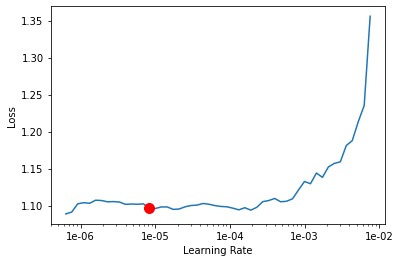

In [36]:
learner.recorder.plot(skip_end=10,suggestion=True)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.904656,0.849778,0.649099,0.350901,00:45


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


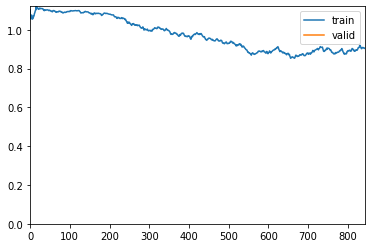

In [37]:
learner.fit_one_cycle(1,max_lr=16e-05,moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.466396,0.429312,0.829887,0.170113,00:55


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


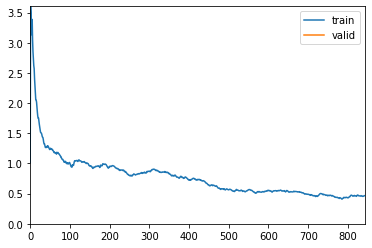

In [42]:
learner.fit_one_cycle(1,max_lr=16e-04,moms=(0.8,0.7))

In [38]:
learner.save('first_cycle')

In [39]:
seed_all(seed)
learner.load('first_cycle');

We then unfreeze the second group of layers and repeat the operations.

In [40]:
learner.freeze_to(-2)

In [43]:
lr = 16e-5

Note here that we use slice to create separate learning rate for each group.

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.422278,0.405162,0.838559,0.161441,00:51


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


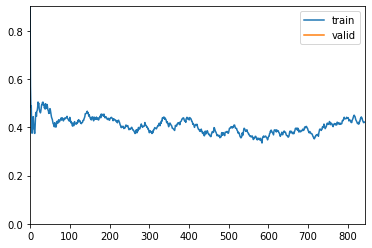

In [44]:
learner.fit_one_cycle(1, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))

In [45]:
learner.save('second_cycle')

In [46]:
seed_all(seed)
learner.load('second_cycle');

In [47]:
learner.freeze_to(-3)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.357520,0.337828,0.871247,0.128752,01:02


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


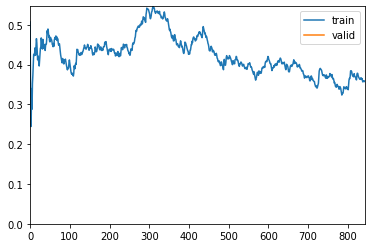

In [48]:
learner.fit_one_cycle(1, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))

In [49]:
learner.save('third_cycle')

In [50]:
seed_all(seed)
learner.load('third_cycle');

Here, we unfreeze all the groups.

In [51]:
learner.unfreeze()

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.428002,0.492189,0.849233,0.150767,02:38
1,0.254940,0.254481,0.918612,0.081388,02:28


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


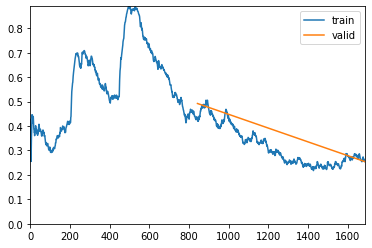

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [52]:
learner.fit_one_cycle(2, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))

Now, you can predict examples with:

In [53]:
learner.predict('I love FASTAI')

(Category tensor(2), tensor(2), tensor([0.0058, 0.0035, 0.9907]))

## Export Learner
In order to export and load the learner the following operations have been done:

In [54]:
learner.export(file = '/content/drive/MyDrive/Internship Dataset/RoBERTa Model/Trained_Model/transformer.pkl');

In [55]:
path = '/content/drive/MyDrive/Internship Dataset/RoBERTa Model/Trained_Model'
export_learner = load_learner(path, file = 'transformer.pkl')

In [56]:
export_learner.predict('This is the worst movie of 2020')

(Category tensor(0), tensor(0), tensor([0.9763, 0.0102, 0.0135]))

## Conclusion
In the above notebook we had performed Sentiment Analysis of Twitter Tweets by integrating and using both the Huggingface Transformer Library and FastAI.
We had used the **Slanted Triangular Learning Rates**, **Discriminate Learning Rate** and even **Gradual Unfreezing** ,as a result, without even tunning the parameters, you can obtain rapidly state-of-the-art results.

# References
* Hugging Face, Transformers GitHub (Nov 2019), [https://github.com/huggingface/transformers](https://github.com/huggingface/transformers)
* Fast.ai, Fastai documentation (Nov 2019), [https://docs.fast.ai/text.html](https://docs.fast.ai/text.html)
* Jeremy Howard & Sebastian Ruder, Universal Language Model Fine-tuning for Text Classification (May 2018), [https://arxiv.org/abs/1801.06146](https://arxiv.org/abs/1801.06146)
* FastAI with HuggingFace Transformer Models
https://towardsdatascience.com/fastai-with-transformers-bert-roberta-xlnet-xlm-distilbert-4f41ee18ecb2